### Import libraries

In [2]:
import re
import nltk
import spacy
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
from googletrans import Translator, constants
from nltk import pos_tag
from nltk.stem.porter import *
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from wordcloud import WordCloud, STOPWORDS
#from scipy.sparse import csr_matrix
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raffl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raffl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raffl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\raffl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Read dataset file

In [7]:
data = pd.read_csv('CTES-Sem1-23-24.csv', encoding='ISO-8859-1')

In [8]:
data.drop(columns=['Lecturer'], inplace=True)

In [9]:
data.head(10)

,No.,Subject,Group,Section,Review,Sentiment,Score,Sentiment_Score
0,1,GFW0001,1,A - A1,tiada,positive,0.661100,4
1,2,GFW0001,1,A - A1,Hackathon pitching is good but still lack of k...,negative,0.060163,1
2,3,GFW0001,1,A - A1,Thank you Prof for being kind with our submiss...,positive,0.907253,5
3,4,GFW0001,1,B - B1,tiada,positive,0.661100,4
4,5,GFW0001,1,B - B1,"With the various background of students, lectu...",positive,0.871617,5
5,6,GFW0001,1,B - B1,Tutorial by doing video is quite burden for me...,neutral,0.560736,3
6,7,GFW0001,1,C - C1,tiada,positive,0.661100,4
7,8,GFW0001,1,C - C1,Can held a physical class once in month. Onlin...,neutral,0.532247,3
8,9,GFW0001,2,A - A1,The tutorials and assignments are quite burden...,positive,0.743488,4
9,10,GFW0001,2,A - A1,The assessment and tutorials for this course s...,negative,0.230553,2


In [10]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

Review             143
No.                  0
Subject              0
Group                0
Section              0
Sentiment            0
Score                0
Sentiment_Score      0
dtype: int64

In [11]:
# Drop rows with missing values in the 'Cadangan' column
data = data.dropna(subset=['Review'])

In [12]:
data.isnull().sum().sort_values(ascending=False)

No.                0
Subject            0
Group              0
Section            0
Review             0
Sentiment          0
Score              0
Sentiment_Score    0
dtype: int64

In [13]:
print(data.shape)

(1750, 8)


### Google Translate

In [14]:
translator = Translator()

In [16]:
try:
    data['English'] = data['Review'].apply(translator.translate, src='malay', dest='en').apply(getattr, args=('text',))
except Exception as e:
    print(f"An error occurred: {e}")

In [17]:
data.head(20)

,No.,Subject,Group,Section,Review,Sentiment,Score,Sentiment_Score,English
0,1,GFW0001,1,A - A1,tiada,positive,0.661100,4,none
1,2,GFW0001,1,A - A1,Hackathon pitching is good but still lack of k...,negative,0.060163,1,Hackathon pitching is good but still lack of k...
2,3,GFW0001,1,A - A1,Thank you Prof for being kind with our submiss...,positive,0.907253,5,Thank you Prof for being kind with our submiss...
3,4,GFW0001,1,B - B1,tiada,positive,0.661100,4,none
4,5,GFW0001,1,B - B1,"With the various background of students, lectu...",positive,0.871617,5,"With the various backgrounds of students, lect..."
5,6,GFW0001,1,B - B1,Tutorial by doing video is quite burden for me...,neutral,0.560736,3,Tutorial by doing video is quite burden for me...
6,7,GFW0001,1,C - C1,tiada,positive,0.661100,4,none
7,8,GFW0001,1,C - C1,Can held a physical class once in month. Onlin...,neutral,0.532247,3,Can hold a physical class once a month. Online...
8,9,GFW0001,2,A - A1,The tutorials and assignments are quite burden...,positive,0.743488,4,The tutorials and assignments are quite burden...
9,10,GFW0001,2,A - A1,The assessment and tutorials for this course s...,negative,0.230553,2,The assessment and tutorials for this course s...


### Data Preprocessing

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, 0 to 1892
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No.              1750 non-null   int64  
 1   Subject          1750 non-null   object 
 2   Group            1750 non-null   object 
 3   Section          1750 non-null   object 
 4   Review           1750 non-null   object 
 5   Sentiment        1750 non-null   object 
 6   Score            1750 non-null   float64
 7   Sentiment_Score  1750 non-null   int64  
 8   English          1750 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 136.7+ KB


In [19]:
data.describe()

,No.,Score,Sentiment_Score
count,1750.000000,1750.000000,1750.000000
mean,931.334857,0.594460,3.553714
std,542.076503,0.216997,1.125222
min,1.000000,0.000367,1.000000
25%,471.250000,0.528587,3.000000
50%,919.500000,0.661100,4.000000
75%,1394.750000,0.727592,4.000000
max,1893.000000,0.979364,5.000000


In [20]:
data.describe(include='object')

,Subject,Group,Section,Review,Sentiment,English
count,1750,1750,1750,1750,1750,1750
unique,74,11,3,988,3,985
top,WOX7001,1,A - A1,-,positive,-
freq,180,614,680,274,1212,274


In [21]:
#Sentiment Distribution
data['Sentiment'].value_counts().sort_index()

Sentiment
negative     349
neutral      189
positive    1212
Name: count, dtype: int64

In [22]:
data['Sentiment'].value_counts(normalize=True).mul(100).round(2).sort_index()

Sentiment
negative    19.94
neutral     10.80
positive    69.26
Name: proportion, dtype: float64

#### 1. Check for null values

In [23]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

No.                0
Subject            0
Group              0
Section            0
Review             0
Sentiment          0
Score              0
Sentiment_Score    0
English            0
dtype: int64

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, 0 to 1892
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   No.              1750 non-null   int64  
 1   Subject          1750 non-null   object 
 2   Group            1750 non-null   object 
 3   Section          1750 non-null   object 
 4   Review           1750 non-null   object 
 5   Sentiment        1750 non-null   object 
 6   Score            1750 non-null   float64
 7   Sentiment_Score  1750 non-null   int64  
 8   English          1750 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 136.7+ KB


### Exploratory Data Analysis

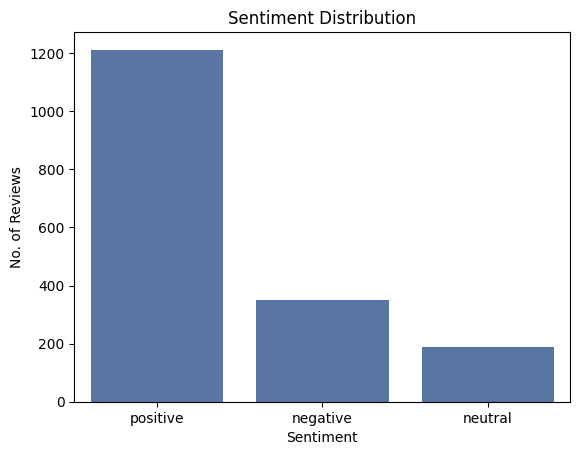

In [25]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='Sentiment')

plt.xlabel('Sentiment')
plt.ylabel('No. of Reviews')
plt.title('Sentiment Distribution')

plt.show()

In [26]:
# Create a new feature containing the length of the reviews
data['review_length'] = data['English'].apply(len)

In [27]:
data.head()

,No.,Subject,Group,Section,Review,Sentiment,Score,Sentiment_Score,English,review_length
0,1,GFW0001,1,A - A1,tiada,positive,0.661100,4,none,4
1,2,GFW0001,1,A - A1,Hackathon pitching is good but still lack of k...,negative,0.060163,1,Hackathon pitching is good but still lack of k...,142
2,3,GFW0001,1,A - A1,Thank you Prof for being kind with our submiss...,positive,0.907253,5,Thank you Prof for being kind with our submiss...,149
3,4,GFW0001,1,B - B1,tiada,positive,0.661100,4,none,4
4,5,GFW0001,1,B - B1,"With the various background of students, lectu...",positive,0.871617,5,"With the various backgrounds of students, lect...",204


Text(0.5, 0, 'Length of the Reviews')

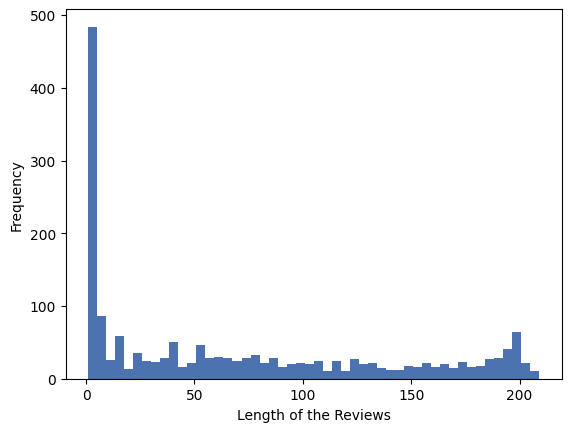

In [28]:
data['review_length'].plot(bins=50, kind='hist') 
plt.xlabel('Length of the Reviews')

array([[<Axes: title={'center': 'negative'}>,
        <Axes: title={'center': 'neutral'}>],
       [<Axes: title={'center': 'positive'}>, <Axes: >]], dtype=object)

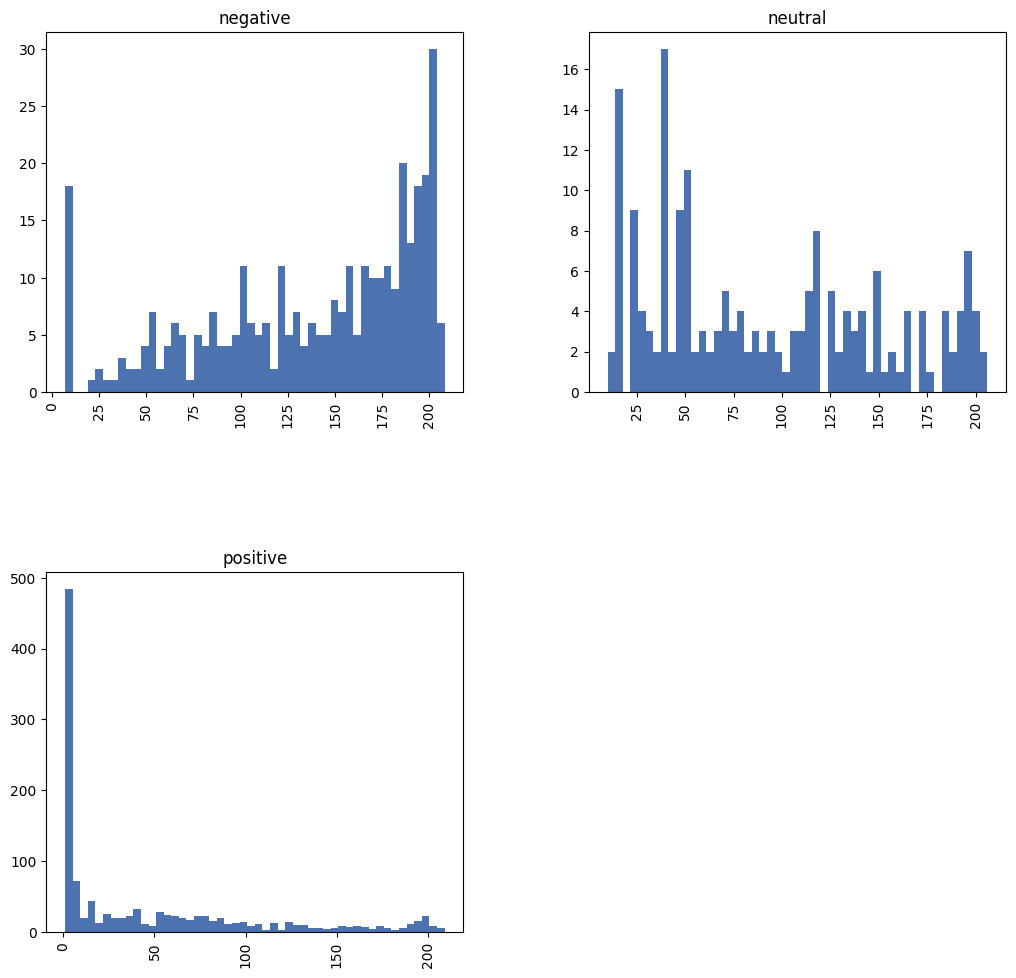

In [29]:
data.hist(column='review_length', by='Sentiment', bins=50,figsize=(12,12))

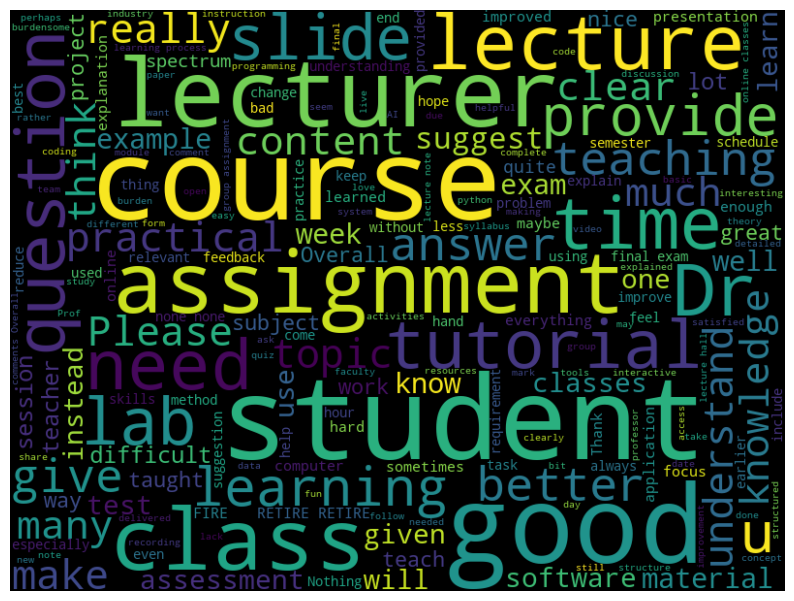

In [30]:
#Review analysis using Wordcloud
all_words = ' '.join([text for text in data['English']])

wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(all_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

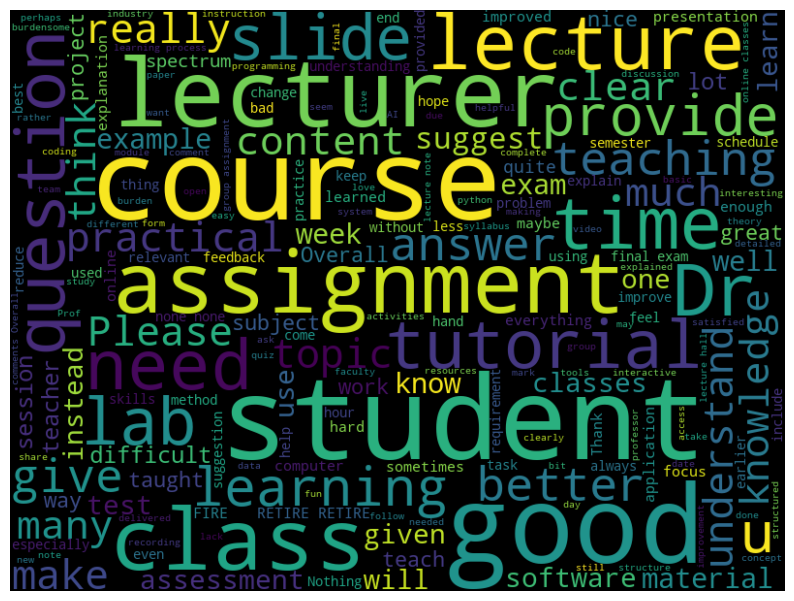

In [31]:
#Neutral reviews
norm_words = ' '.join([text for text in data['English'][data['Score'] != 0.5]])

wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(norm_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

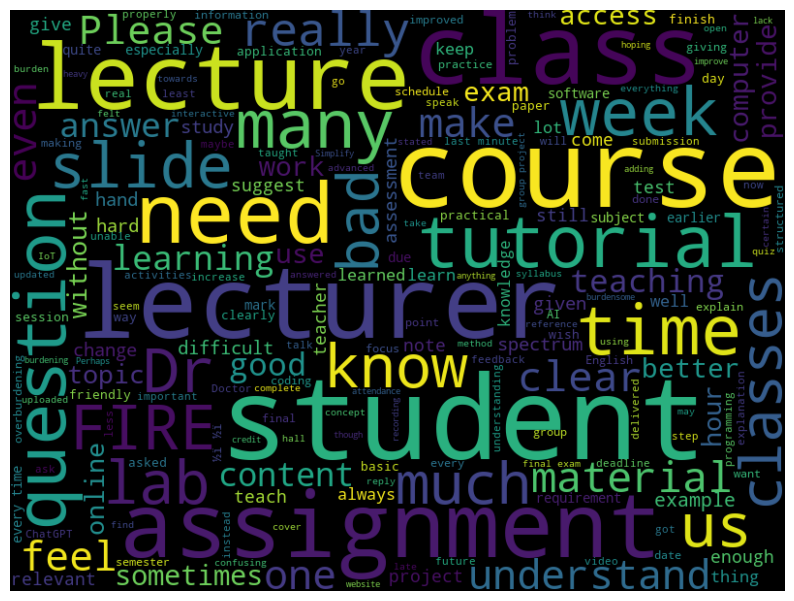

In [32]:
#Negative reviews
neg_words = ' '.join([text for text in data['English'][data['Score'] < 0.4]])

wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(neg_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

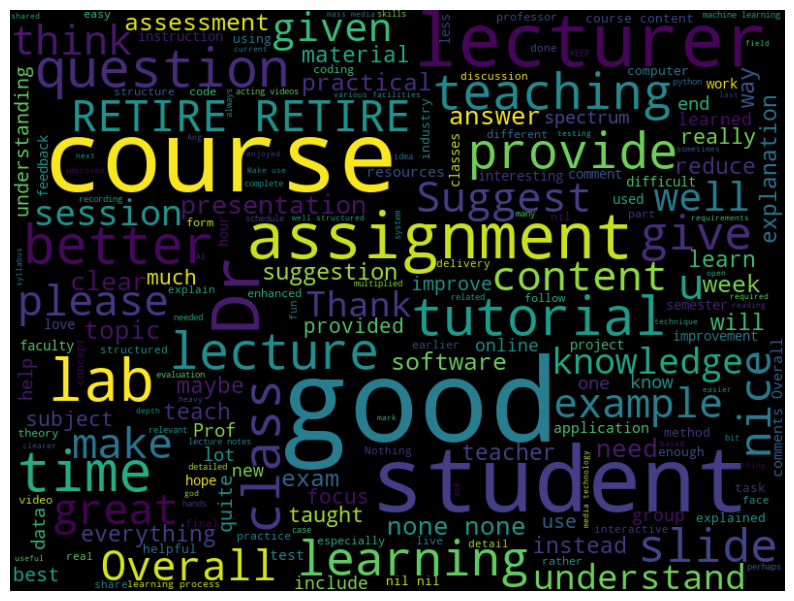

In [33]:
#Positive reviews
pos_words = ' '.join([text for text in data['English'][data['Score'] > 0.6]])

wordcloud = WordCloud(width = 800, height = 600, random_state = 21, max_font_size = 120).generate(pos_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Text Pre-processing

In [166]:
import unicodedata

In [167]:
# Define a function to map POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [168]:
# Function for text preprocessing
def preprocess_text(text):

    # Initialize WordNet Lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Convert text to lowercase
    text = text.lower()

    # Normalize text (Remove accents, diacritics, etc.)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    
    # Remove special characters (except for words starting with 'not_')
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Initialize a variable to keep track of whether the current token follows a negation
    following_negation = False
    
    # Iterate over tokens and modify sentiment of words that follow negations
    for i in range(len(tokens)):
        token = tokens[i]
        if token in ["not", "no"]:
            following_negation = True
        elif following_negation:
            # Modify sentiment of the word
            tokens[i] = "not_" + tokens[i]
            following_negation = False
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Remove non-alphanumeric characters except for words starting with 'not_'
    tokens = [token for token in tokens if token.isalnum() or token.startswith('not_')]
    
    # Whitespace removal
    tokens = [token.strip() for token in tokens]
    
    # POS tags for lemmatization
    pos_tags = pos_tag(tokens)

    # Lemmatization
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [39]:
# Apply text preprocessing to the 'text' column
try:
    data['preprocessed_text'] = data['English'].apply(preprocess_text)
except Exception as e:
        print(f"An error occurred: {e}")

In [41]:
data.head(20)

,No.,Subject,Group,Section,Review,Sentiment,Score,Sentiment_Score,English,review_length,preprocessed_text
0,1,GFW0001,1,A - A1,tiada,positive,0.661100,4,none,4,none
1,2,GFW0001,1,A - A1,Hackathon pitching is good but still lack of k...,negative,0.060163,1,Hackathon pitching is good but still lack of k...,142,hackathon pitch good still lack knowledge expe...
2,3,GFW0001,1,A - A1,Thank you Prof for being kind with our submiss...,positive,0.907253,5,Thank you Prof for being kind with our submiss...,149,thank prof kind submission weekly tutorial hop...
3,4,GFW0001,1,B - B1,tiada,positive,0.661100,4,none,4,none
4,5,GFW0001,1,B - B1,"With the various background of students, lectu...",positive,0.871617,5,"With the various backgrounds of students, lect...",204,various background student lecturer guide stud...
5,6,GFW0001,1,B - B1,Tutorial by doing video is quite burden for me...,neutral,0.560736,3,Tutorial by doing video is quite burden for me...,206,tutorial video quite burden replace fun activi...
6,7,GFW0001,1,C - C1,tiada,positive,0.661100,4,none,4,none
7,8,GFW0001,1,C - C1,Can held a physical class once in month. Onlin...,neutral,0.532247,3,Can hold a physical class once a month. Online...,117,hold physical class month online already good ...
8,9,GFW0001,2,A - A1,The tutorials and assignments are quite burden...,positive,0.743488,4,The tutorials and assignments are quite burden...,73,tutorial assignment quite burdensome elective ...
9,10,GFW0001,2,A - A1,The assessment and tutorials for this course s...,negative,0.230553,2,The assessment and tutorials for this course s...,164,assessment tutorial course revise work need co...


In [42]:
data.dtypes

No.                    int64
Subject               object
Group                 object
Section               object
Review                object
Sentiment             object
Score                float64
Sentiment_Score        int64
English               object
review_length          int64
preprocessed_text     object
dtype: object

In [43]:
import collections 
from collections import Counter

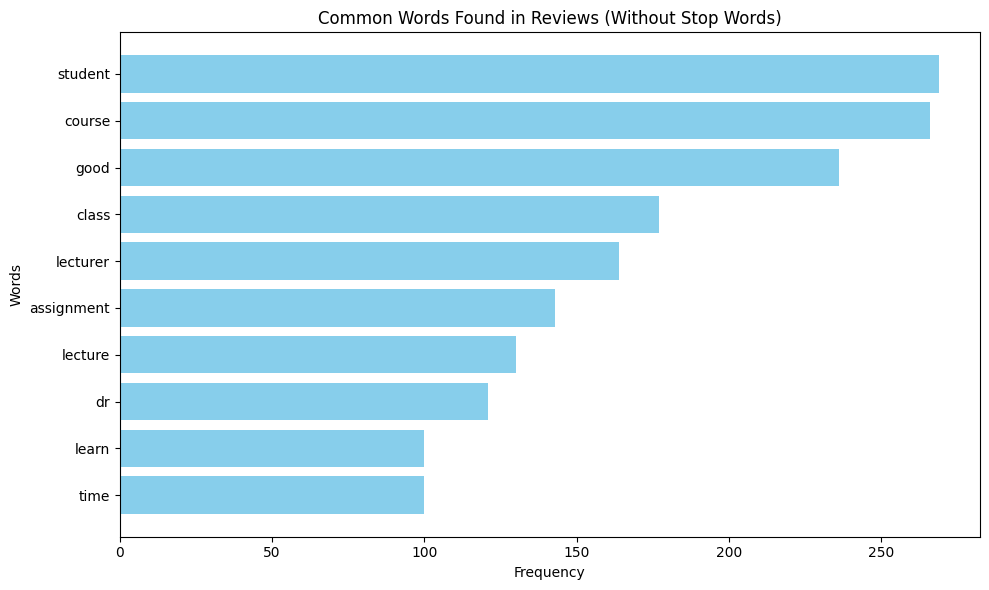

In [44]:
# Sample reviews (replace with actual reviews)
reviews = data['English'].tolist()

# Preprocess the reviews
preprocessed_reviews = [preprocess_text(review) for review in reviews]

# Tokenize the preprocessed reviews
all_tokens = [word_tokenize(review) for review in preprocessed_reviews]

# Flatten the list of tokens
flat_tokens = [token for sublist in all_tokens for token in sublist]

# Count the frequency of each word
word_counts = Counter(flat_tokens)

# Remove stopwords (customize this list as needed)
stop_words = set(stopwords.words('english'))
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words}

# Sort the filtered word counts by frequency
sorted_word_counts = dict(sorted(filtered_word_counts.items(), key=lambda item: item[1], reverse=True))

# Get the top N common words (customize N as needed)
top_n = 10
common_words = list(sorted_word_counts.keys())[:top_n]
common_word_counts = list(sorted_word_counts.values())[:top_n]

# Plot the horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(common_words, common_word_counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Common Words Found in Reviews (Without Stop Words)')
plt.gca().invert_yaxis()  # Invert y-axis to show most frequent words on top
plt.tight_layout()
plt.show()

In [45]:
# Display the number of records with missing values
missing_values_count = data.isnull().sum()
print("Number of records with missing values:")
print(missing_values_count)

Number of records with missing values:
No.                  0
Subject              0
Group                0
Section              0
Review               0
Sentiment            0
Score                0
Sentiment_Score      0
English              0
review_length        0
preprocessed_text    0
dtype: int64


In [46]:
data.drop(columns=['Group','Section','Review','Score','English','review_length'], inplace=True)

In [47]:
data['Sentiment'].value_counts(normalize=True).mul(100).round(2)

Sentiment
positive    69.26
negative    19.94
neutral     10.80
Name: proportion, dtype: float64

In [50]:
# Save the DataFrame as a CSV file
data.to_csv('cleaned_CTES.csv', index=False)

In [51]:
# Create dataframe
df = pd.read_csv('cleaned_CTES.csv')

In [52]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

No.                    0
Subject                0
Sentiment              0
Sentiment_Score        0
preprocessed_text    339
dtype: int64


In [53]:
df = df.dropna(subset=['preprocessed_text'])

In [54]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

No.                  0
Subject              0
Sentiment            0
Sentiment_Score      0
preprocessed_text    0
dtype: int64


In [73]:
df['preprocessed_text'].replace(['none', 'nothing','nil','1'], np.nan, inplace=True)

In [74]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

No.                   0
Subject               0
Sentiment             0
Sentiment_Score       0
preprocessed_text    89
dtype: int64


In [75]:
df = df.dropna(subset=['preprocessed_text'])

In [76]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

No.                  0
Subject              0
Sentiment            0
Sentiment_Score      0
preprocessed_text    0
dtype: int64


In [78]:
df.to_csv('cleaned_CTES_data.csv', index=False)
new_df = pd.read_csv('cleaned_CTES_data.csv')

In [107]:
import pickle

# Save the dataframe
with open('preprocessed_data.pkl', 'wb') as file:
    pickle.dump(new_df, file)

### Train test split

In [23]:
new_df = pd.read_csv('cleaned_CTES_data.csv')

In [24]:
X = new_df['preprocessed_text']
y = new_df['Sentiment']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Extraction

#### Count Vectors as Features

In [26]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [46]:
# Save the Count vectorizer
with open('count_vect.pkl', 'wb') as file:
    pickle.dump(count_vect, file)

#### TF-IDF Vectors as Features

1. Word level
2. N-gram level
3. Character level

In [27]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
CPU times: total: 31.2 ms
Wall time: 27.1 ms


In [44]:
# Save the TF-IDF vectorizer
with open('tfidf_vect_word.pkl', 'wb') as file:
    pickle.dump(tfidf_vect, file)

In [28]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: total: 0 ns
Wall time: 52.9 ms


In [43]:
# Save the TF-IDF vectorizer
with open('tfidf_vect_ngram.pkl', 'wb') as file:
    pickle.dump(tfidf_vect_ngram, file)

In [29]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')
CPU times: total: 78.1 ms
Wall time: 125 ms


c:\Users\raffl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [41]:
# Save the TF-IDF vectorizer
with open('tfidf_vect_chars.pkl', 'wb') as file:
    pickle.dump(tfidf_vect_ngram_chars, file)

### Model Building

In [33]:
## helper function

def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    accuracy = accuracy_score(predictions, y_test)
    
    return accuracy

In [34]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Count Vectors',
                                  'WordLevel TF-IDF',
                                  'N-Gram Vectors',
                                  'CharLevel Vectors'])

### Logistic Regression

It is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

In [47]:
params_log = {'penalty': ['l2'], 
             'C': np.logspace(-4, 4, 10)}
clf_log = GridSearchCV(LogisticRegression(solver = 'lbfgs', random_state=42, multi_class='multinomial'), params_log, cv=5, error_score='raise')

In [48]:
%%time
clf_log.fit(X_train_count, y_train)

CPU times: total: 188 ms
Wall time: 606 ms


GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l2']})

In [49]:
clf_log.best_estimator_

LogisticRegression(C=2.782559402207126, multi_class='multinomial',
                   random_state=42)

In [50]:
%%time
# Logistic Regression on Count Vectors
accuracy1  = train_model(clf_log.best_estimator_, X_train_count, y_train, X_test_count)
print('LR, Count Vectors    : %.4f\n' % accuracy1)

LR, Count Vectors    : 0.6981

CPU times: total: 15.6 ms
Wall time: 34.8 ms


In [51]:
%%time
# Logistic Regression on WordLevel TF-IDF
accuracy2 = train_model(clf_log.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('LR, WordLevel TF-IDF    : %.4f\n' % accuracy2)

LR, WordLevel TF-IDF    : 0.7170

CPU times: total: 0 ns
Wall time: 26 ms


In [52]:
%%time
# Logistic Regression on N-Gram Vectors
accuracy3 = train_model(clf_log.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('LR, N-Gram Vectors    : %.4f\n' % accuracy3)

LR, N-Gram Vectors    : 0.6566

CPU times: total: 141 ms
Wall time: 151 ms


In [53]:
%%time
# Logistic Regression on CharLevel Vectors
accuracy4 = train_model(clf_log.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('LR, CharLevel Vectors    : %.4f\n' % accuracy4)

LR, CharLevel Vectors    : 0.7358

CPU times: total: 125 ms
Wall time: 172 ms


In [54]:
results.loc['Logistic Regression'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [56]:
# Save the trained model
with open('log_model1.pkl', 'wb') as file:
    pickle.dump(clf_log, file)

### Support Vector Classifier

In [57]:
clf_SVC = LinearSVC(random_state=42)

In [58]:
%%time
clf_SVC.fit(X_train_count, y_train)

CPU times: total: 0 ns
Wall time: 24.5 ms


LinearSVC(random_state=42)

In [59]:
%%time
# Support Vector Machine on Count Vectors
accuracy1 = train_model(clf_SVC, X_train_count, y_train, X_test_count)
print('SVM, Count Vectors    : %.4f\n' % accuracy1)

SVM, Count Vectors    : 0.7094

CPU times: total: 31.2 ms
Wall time: 27.7 ms


In [60]:
%%time
# Support Vector Machine on WordLevel TF-IDF
accuracy2 = train_model(clf_SVC, X_train_tfidf, y_train, X_test_tfidf)
print('SVM, WordLevel TF-IDF    : %.4f\n' % accuracy2)

SVM, WordLevel TF-IDF    : 0.7245

CPU times: total: 15.6 ms
Wall time: 14.9 ms


In [61]:
%%time
# Support Vector Machine on N-Gram Vectors
accuracy3 = train_model(clf_SVC, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SVM, N-Gram Vectors    : %.4f\n' % accuracy3)

SVM, N-Gram Vectors    : 0.6491

CPU times: total: 0 ns
Wall time: 4.11 ms


In [62]:
%%time
# Support Vector Machine on CharLevel Vectors
accuracy4 = train_model(clf_SVC, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SVM, CharLevel Vectors    : %.4f\n' % accuracy4)

SVM, CharLevel Vectors    : 0.7321

CPU times: total: 0 ns
Wall time: 34.8 ms


In [63]:
results.loc['Support Vector Machine'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [64]:
# Save the trained model
with open('svc_model2.pkl', 'wb') as file:
    pickle.dump(clf_SVC, file)

### Stochastic Gradient Descent Classifier

In [65]:
params_SGD = {'loss': ['hinge', 'modified_huber', 'squared_hinge'],
              'penalty': ['l1', 'l2'], 
              'alpha': np.linspace(0.1, 1, 10)}
clf_SGD = GridSearchCV(SGDClassifier(random_state=42), params_SGD, cv=5)

In [66]:
# Create the GridSearchCV object with error_score='raise'
clf_SGD = GridSearchCV(SGDClassifier(random_state=42), params_SGD, cv=5, error_score='raise')

In [67]:
%%time
clf_SGD.fit(X_train_count, y_train)

c:\Users\raffl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\raffl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


CPU times: total: 406 ms
Wall time: 1.79 s


GridSearchCV(cv=5, error_score='raise',
             estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'loss': ['hinge', 'modified_huber', 'squared_hinge'],
                         'penalty': ['l1', 'l2']})

In [68]:
clf_SGD.best_estimator_

SGDClassifier(alpha=0.1, loss='modified_huber', random_state=42)

In [69]:
%%time
# SGD on Count Vectors
accuracy1 = train_model(clf_SGD.best_estimator_, X_train_count, y_train, X_test_count)
print('SGD, Count Vectors    : %.4f\n' % accuracy1)

SGD, Count Vectors    : 0.6491

CPU times: total: 15.6 ms
Wall time: 19.4 ms


In [70]:
%%time
# SGD on WordLevel TF-IDF
accuracy2 = train_model(clf_SGD.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('SGD, WordLevel TF-IDF    : %.4f\n' % accuracy2)

SGD, WordLevel TF-IDF    : 0.5660

CPU times: total: 0 ns
Wall time: 8.2 ms


In [71]:
%%time
# SGD on N-Gram Vectors
accuracy3 = train_model(clf_SGD.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('SGD, N-Gram Vectors    : %.4f\n' % accuracy3)

SGD, N-Gram Vectors    : 0.5547

CPU times: total: 0 ns
Wall time: 7.6 ms


In [72]:
%%time
# SGD on CharLevel Vectors
accuracy4 = train_model(clf_SGD.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('SGD, CharLevel Vectors    : %.4f\n' % accuracy4)

SGD, CharLevel Vectors    : 0.5660

CPU times: total: 0 ns
Wall time: 13.6 ms


In [73]:
results.loc['Stochastic Gradient Descent'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [74]:
# Save the trained model
with open('sgd_model3.pkl', 'wb') as file:
    pickle.dump(clf_SGD, file)

### Naive Bayes Classifier

In [75]:
param_NB = {'alpha': np.linspace(0.1, 1, 10)}
clf_NB = GridSearchCV(MultinomialNB(), param_NB, cv=5)

In [76]:
%%time
clf_NB.fit(X_train_count, y_train)

CPU times: total: 62.5 ms
Wall time: 145 ms


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [77]:
clf_NB.best_estimator_

MultinomialNB(alpha=0.8)

In [78]:
%%time
# Naive Bayes on Count Vectors
accuracy1 = train_model(clf_NB.best_estimator_, X_train_count, y_train, X_test_count)
print('NB, Count Vectors    : %.4f\n' % accuracy1)

NB, Count Vectors    : 0.6981

CPU times: total: 0 ns
Wall time: 4.04 ms


In [79]:
%%time
# Naive Bayes on Word Level TF IDF Vectors
accuracy2 = train_model(clf_NB.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
print('NB, WordLevel TF-IDF : %.4f\n' % accuracy2)

NB, WordLevel TF-IDF : 0.6528

CPU times: total: 0 ns
Wall time: 0 ns


In [80]:
%%time
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_NB.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('NB, N-Gram Vectors   : %.4f\n' % accuracy3)

NB, N-Gram Vectors   : 0.6491

CPU times: total: 0 ns
Wall time: 4 ms


In [81]:
%%time
# # Naive Bayes on Character Level TF IDF Vectors
accuracy4 = train_model(clf_NB.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('NB, CharLevel Vectors: %.4f\n' % accuracy4)

NB, CharLevel Vectors: 0.6340

CPU times: total: 0 ns
Wall time: 0 ns


In [82]:
results.loc['Naive Bayes'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [83]:
# Save the trained model
with open('nb_model4.pkl', 'wb') as file:
    pickle.dump(clf_NB, file)

### K Nearest Neighbours

In [84]:
params_KNN = {'metric': ['euclidean', 'manhattan'],
 'n_neighbors': np.arange(1, 16)}
clf_KNN = GridSearchCV(KNeighborsClassifier(), params_KNN, cv=5)

In [85]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [86]:
%%time
clf_KNN.fit(X_train_count, y_train)

CPU times: total: 10 s
Wall time: 2.6 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [87]:
clf_KNN.best_estimator_

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [88]:
%%time
# KNN on Count Vectors
accuracy1 = train_model(clf_KNN.best_estimator_, X_train_count, y_train, X_test_count)
print('KNN, Count Vectors    : %.4f\n' % accuracy1)

KNN, Count Vectors    : 0.6453

CPU times: total: 109 ms
Wall time: 29.8 ms


In [90]:
%%time
# KNN on Word Level TF IDF Vectors
#accuracy2 = train_model(clf_KNN.best_estimator_, X_train_tfidf, y_train, X_test_tfidf)
#print('KNN, WordLevel TF-IDF : %.4f\n' % accuracy2)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
# KNN on Ngram Level TF IDF Vectors
#accuracy3 = train_model(clf_KNN.best_estimator_, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
#print('KNN, N-Gram Vectors   : %.4f\n' % accuracy3)

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
%%time
# KNN on Character Level TF IDF Vectors
#accuracy4 = train_model(clf_KNN.best_estimator_, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
#print('KNN, CharLevel Vectors: %.4f\n' % accuracy4)

CPU times: total: 0 ns
Wall time: 0 ns


In [91]:
results.loc['K-Nearest Neighbors'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [92]:
# Save the trained model
with open('knn_model5.pkl', 'wb') as file:
    pickle.dump(clf_KNN, file)

### Decision Trees

In [93]:
clf_dt = DecisionTreeClassifier()

In [94]:
%%time
clf_dt.fit(X_train_count, y_train)

CPU times: total: 0 ns
Wall time: 52.2 ms


DecisionTreeClassifier()

In [95]:
%%time
# Decision Tree on Count Vectors
accuracy1 = train_model(clf_dt, X_train_count, y_train, X_test_count)
print('DT, Count Vectors    : %.4f\n' % accuracy1)

DT, Count Vectors    : 0.6491

CPU times: total: 31.2 ms
Wall time: 70.2 ms


In [96]:
%%time
# Decision Tree on Word Level TF IDF Vectors
accuracy2 = train_model(clf_dt, X_train_tfidf, y_train, X_test_tfidf)
print('DT, WordLevel TF-IDF : %.4f\n' % accuracy2)

DT, WordLevel TF-IDF : 0.6755

CPU times: total: 15.6 ms
Wall time: 57.1 ms


In [97]:
%%time
# Decision Tree on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_dt, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('DT, N-Gram Vectors   : %.4f\n' % accuracy3)

DT, N-Gram Vectors   : 0.6264

CPU times: total: 156 ms
Wall time: 370 ms


In [98]:
%%time
# Decision Tree on Character Level TF IDF Vectors
accuracy4 = train_model(clf_dt, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('DT, CharLevel Vectors: %.4f\n' % accuracy4)

DT, CharLevel Vectors: 0.7245

CPU times: total: 156 ms
Wall time: 271 ms


In [99]:
results.loc['Decision Tree'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [100]:
# Save the trained model
with open('dt_model6.pkl', 'wb') as file:
    pickle.dump(clf_dt, file)

### Random Forest

It is a supervised classification algorithm. As the name suggest, this algorithm creates the forest with a number of trees. It is a kind of ensemble learning method, where a few weak models combine to form a powerful model. In Random Forest, we grow multiple trees as opposed to a decision single tree. To classify a new object based on attributes, each tree gives a classification and we say the tree “votes” for that class. The forest chooses the classification having the most votes (over all the trees in the forest).

In [101]:
clf_rf = RandomForestClassifier(random_state=42)

In [102]:
%%time
clf_rf.fit(X_train_count, y_train)

CPU times: total: 62.5 ms
Wall time: 643 ms


RandomForestClassifier(random_state=42)

In [103]:
%%time
# Random Forest on Count Vectors
accuracy1 = train_model(clf_rf, X_train_count, y_train, X_test_count)
print('RF, Count Vectors    : %.4f\n' % accuracy1)

RF, Count Vectors    : 0.7132

CPU times: total: 250 ms
Wall time: 737 ms


In [104]:
%%time
# Random Forest on Word Level TF IDF Vectors
accuracy2 = train_model(clf_rf, X_train_tfidf, y_train, X_test_tfidf)
print('RF, WordLevel TF-IDF : %.4f\n' % accuracy2)

RF, WordLevel TF-IDF : 0.7208

CPU times: total: 172 ms
Wall time: 712 ms


In [105]:
%%time
# Random Forest on Ngram Level TF IDF Vectors
accuracy3 = train_model(clf_rf, X_train_tfidf_ngram, y_train, X_test_tfidf_ngram)
print('RF, N-Gram Vectors   : %.4f\n' % accuracy3)

RF, N-Gram Vectors   : 0.6604

CPU times: total: 547 ms
Wall time: 1.64 s


In [106]:
%%time
# Random Forest on Character Level TF IDF Vectors
accuracy4 = train_model(clf_rf, X_train_tfidf_ngram_chars, y_train, X_test_tfidf_ngram_chars)
print('RF, CharLevel Vectors: %.4f\n' % accuracy4)

RF, CharLevel Vectors: 0.7849

CPU times: total: 250 ms
Wall time: 640 ms


In [107]:
results.loc['Random Forest'] = {
    'Count Vectors': accuracy1,
    'WordLevel TF-IDF': accuracy2,
    'N-Gram Vectors': accuracy3,
    'CharLevel Vectors': accuracy4}

In [108]:
# Save the trained model
with open('rf_model7.pkl', 'wb') as file:
    pickle.dump(clf_rf, file)

In [109]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Logistic Regression,0.698113,0.716981,0.656604,0.735849
Support Vector Machine,0.709434,0.724528,0.649057,0.732075
Stochastic Gradient Descent,0.649057,0.566038,0.554717,0.566038
Naive Bayes,0.698113,0.652830,0.649057,0.633962
K-Nearest Neighbors,0.645283,0.652830,0.649057,0.633962
Decision Tree,0.649057,0.675472,0.626415,0.724528
Random Forest,0.713208,0.720755,0.660377,0.784906


### Comparing best models using ROC curve

#### Change target variable into binary class

In [110]:
codes = {'negative':-1, 'neutral':0, 'positive':1}

In [111]:
new_df['Sentiment'] = new_df.Sentiment.map(codes)

In [112]:
new_df = new_df[new_df.Sentiment != 0]

In [113]:
new_df.sentiment = new_df.Sentiment.replace(-1, 0)

C:\Users\raffl\AppData\Local\Temp\ipykernel_11692\836461753.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  new_df.sentiment = new_df.Sentiment.replace(-1, 0)


In [114]:
new_df.head()

,No.,Subject,Sentiment,Sentiment_Score,preprocessed_text
0,2,GFW0001,-1,1,hackathon pitch good still lack knowledge expe...
1,3,GFW0001,1,5,thank prof kind submission weekly tutorial hop...
2,5,GFW0001,1,5,various background student lecturer guide stud...
5,9,GFW0001,1,4,tutorial assignment quite burdensome elective ...
6,10,GFW0001,-1,2,assessment tutorial course revise work need co...


In [115]:
new_df.shape

(1133, 5)

#### Rerun feature selection, data splitting and feature engineering

In [116]:
# Features and Labels
X = new_df['preprocessed_text']
y = new_df['Sentiment'] 

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [117]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(X)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

In [119]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

tfidf_vect.fit(X)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(max_features=5000, token_pattern='\\w{1,}')
CPU times: total: 0 ns
Wall time: 23.4 ms


In [121]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

tfidf_vect_ngram.fit(X)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: total: 31.2 ms
Wall time: 58.8 ms


In [123]:
%%time
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer = 'char',
                                         token_pattern = r'\w{1,}',
                                         ngram_range = (2, 3),
                                         max_features = 5000)
print(tfidf_vect_ngram_chars)

tfidf_vect_ngram_chars.fit(X)
X_train_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
X_test_tfidf_ngram_chars  = tfidf_vect_ngram_chars.transform(X_test)

TfidfVectorizer(analyzer='char', max_features=5000, ngram_range=(2, 3),
                token_pattern='\\w{1,}')
CPU times: total: 31.2 ms
Wall time: 97.2 ms


c:\Users\raffl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


### Modelling for Bernoulli prediction accuracy using different features

* The results dataframe told us what features make the best regressors/ predictors
* Here, we want to determine which models make the best predictions
* Hence, we use bag-of-words features (i.e. Count Vectorizer) not because it produces the best accuracy scores, as even TF-IDF arguably minimizes overfitting with detection of common words, but because it is sufficient for the purpose described.

In [125]:
def summary_report(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    pred_proba_ = classifier.predict_proba(feature_vector_valid)
    
    accuracy_ = accuracy_score(y_test, predictions)
    precision_ = precision_score(y_test, predictions)
    recall_ = recall_score(y_test, predictions)
    roc_auc_ = roc_auc_score(y_test, predictions)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(y_test, predictions)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, pred_proba_[:,1])
    roc_auc = auc(fpr, tpr)
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax=ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
     # ROC
    ax[1].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[1].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic')
    ax[1].legend(loc = 'lower right')

    plt.show()
    
    return (fpr, tpr, roc_auc)

#### ROC curve: Logistic Regression

In [126]:
%%time
# Retrain logistic regression model with binary target
clf_log.fit(X_train_count, y_train)

CPU times: total: 31.2 ms
Wall time: 363 ms


GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=42),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l2']})

Accuracy : 0.7930 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7879 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9155 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7519                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


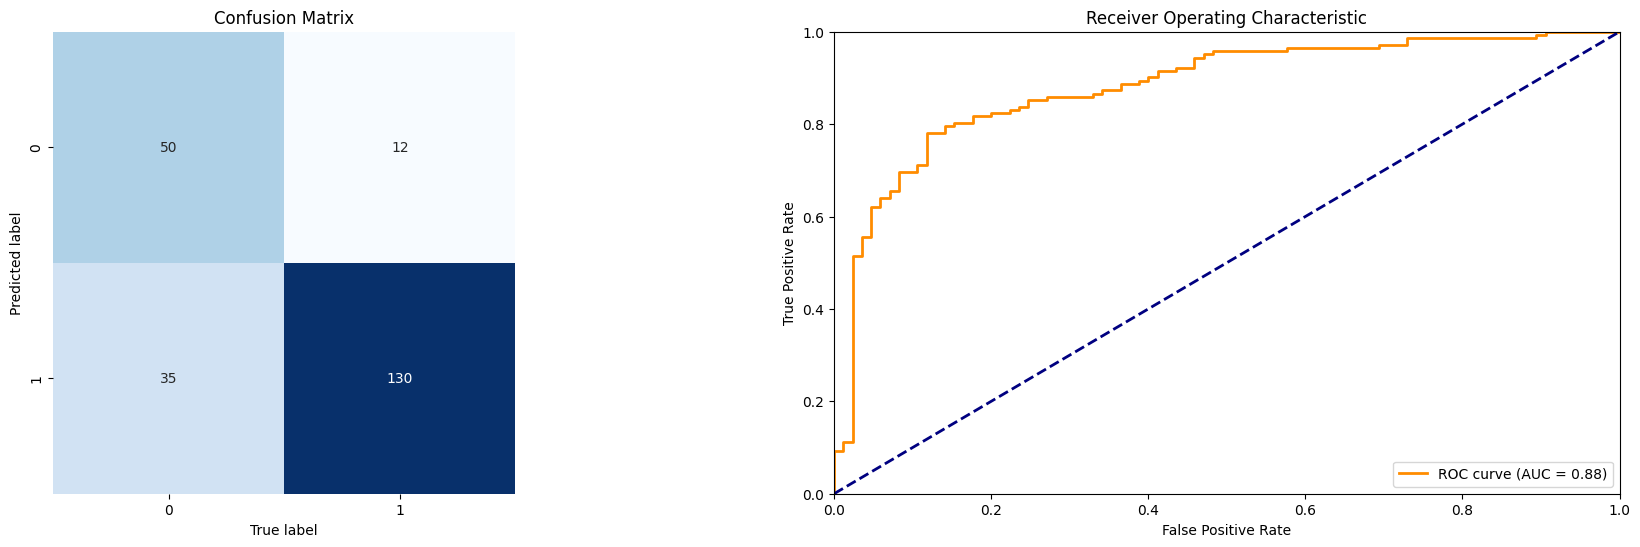

CPU times: total: 46.9 ms
Wall time: 216 ms


In [127]:
%%time
# Logistic Regression on Count Vectors
fpr1, tpr1, roc_auc1 = summary_report(clf_log.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: Stochastic Gradient Descent

In [130]:
%%time
# Retrain SGD model with binary target
clf_SGD.fit(X_train_count, y_train)

c:\Users\raffl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:723: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


CPU times: total: 250 ms
Wall time: 884 ms


GridSearchCV(cv=5, error_score='raise',
             estimator=SGDClassifier(random_state=42),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'loss': ['hinge', 'modified_huber', 'squared_hinge'],
                         'penalty': ['l1', 'l2']})

Accuracy : 0.7489 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7348 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9366 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6860                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


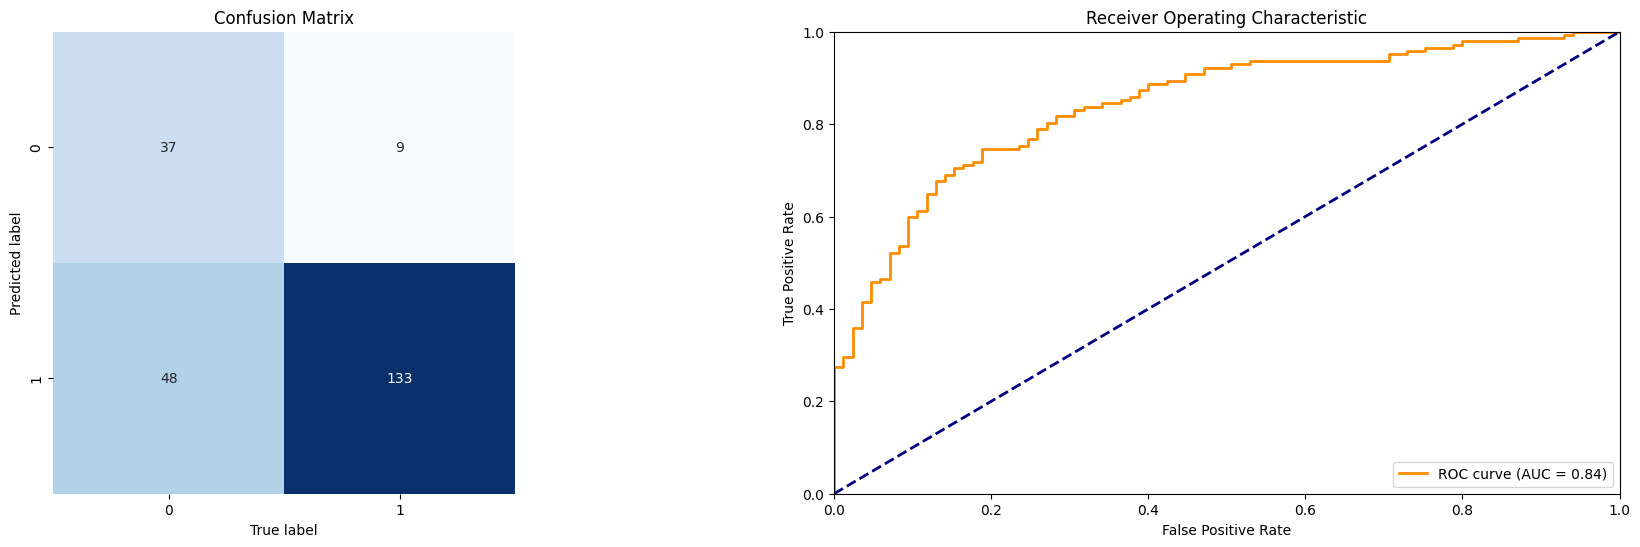

CPU times: total: 62.5 ms
Wall time: 155 ms


In [131]:
%%time
# SGD on Count Vectors
fpr3, tpr3, roc_auc3  = summary_report(clf_SGD.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: Naive Bayes

In [133]:
%%time
# Retrain Naive Bayes model with binary target
clf_NB.fit(X_train_count, y_train)

CPU times: total: 46.9 ms
Wall time: 108 ms


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

Accuracy : 0.8370 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8477 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9014 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8154                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


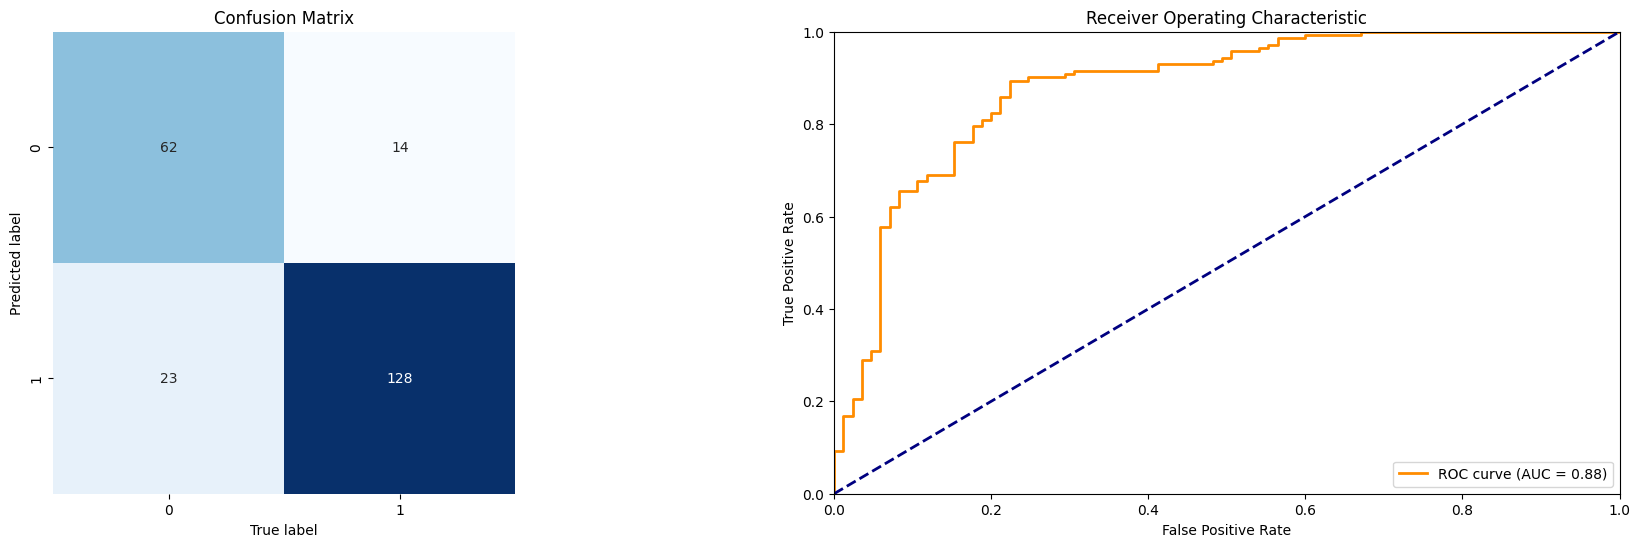

CPU times: total: 15.6 ms
Wall time: 146 ms


In [134]:
%%time
# Naive Bayes on Count Vectors
fpr4, tpr4, roc_auc4  = summary_report(clf_NB.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: K-nearest Neighbors

In [136]:
%%time
# Retrain KNN model with binary target
clf_KNN.fit(X_train_count, y_train)

CPU times: total: 8.31 s
Wall time: 2.07 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

Accuracy : 0.7225 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7026 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9648 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6412                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


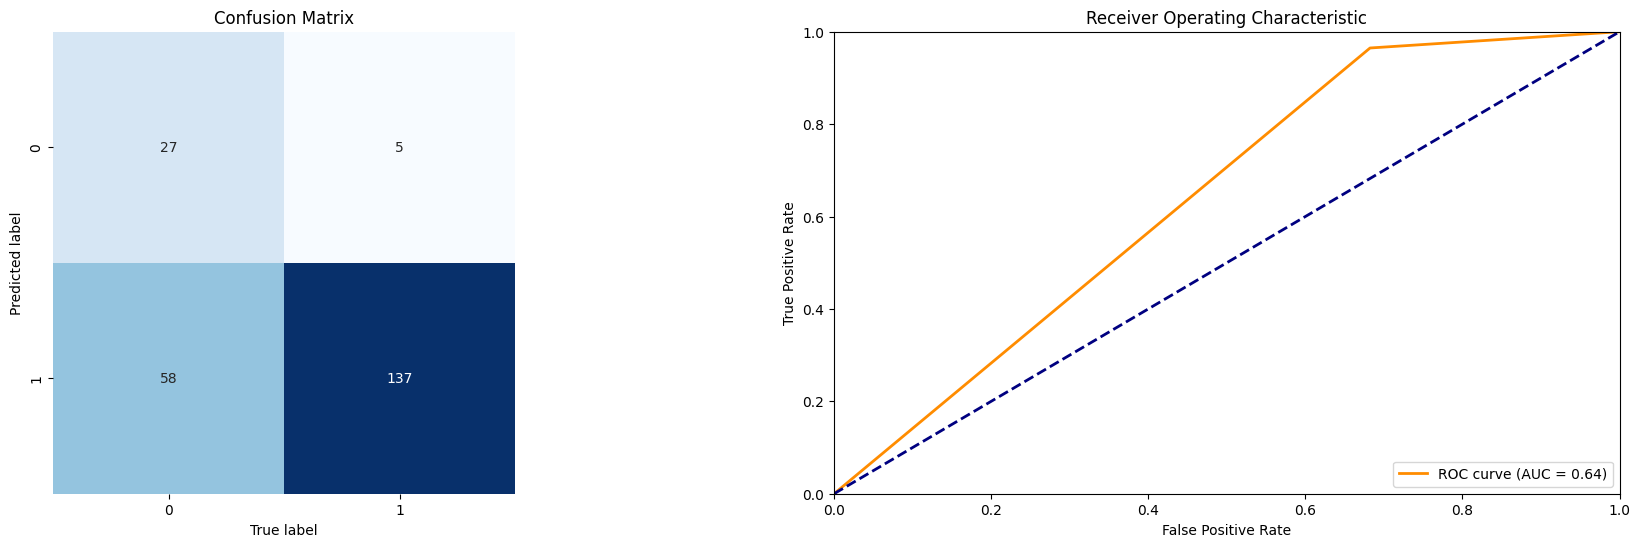

CPU times: total: 46.9 ms
Wall time: 283 ms


In [137]:
%%time
# KNN on Count Vectors
fpr5, tpr5, roc_auc5  = summary_report(clf_KNN.best_estimator_, X_train_count, y_train, X_test_count)

#### ROC curve: Decision Tree

In [139]:
%%time
# Retrain decision tree model with binary target
clf_dt.fit(X_train_count, y_train)

CPU times: total: 31.2 ms
Wall time: 43 ms


DecisionTreeClassifier()

Accuracy : 0.7885 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7831 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9155 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7460                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


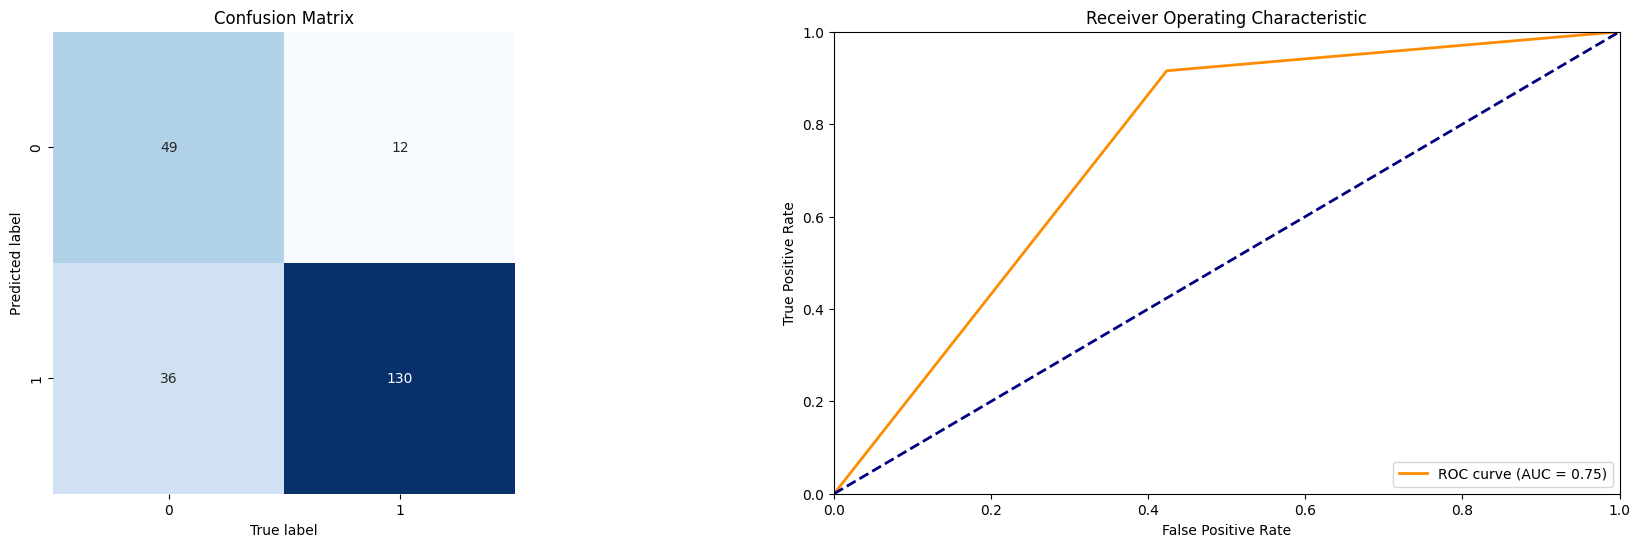

In [140]:
fpr6, tpr6, roc_auc6  = summary_report(clf_dt, X_train_count, y_train, X_test_count)

#### ROC curve: Random Forest

In [142]:
%%time
# Retrain decision tree model with binary target
clf_rf.fit(X_train_count, y_train)

CPU times: total: 172 ms
Wall time: 458 ms


RandomForestClassifier(random_state=42)

Accuracy : 0.7885 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7582 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9718 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7271                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


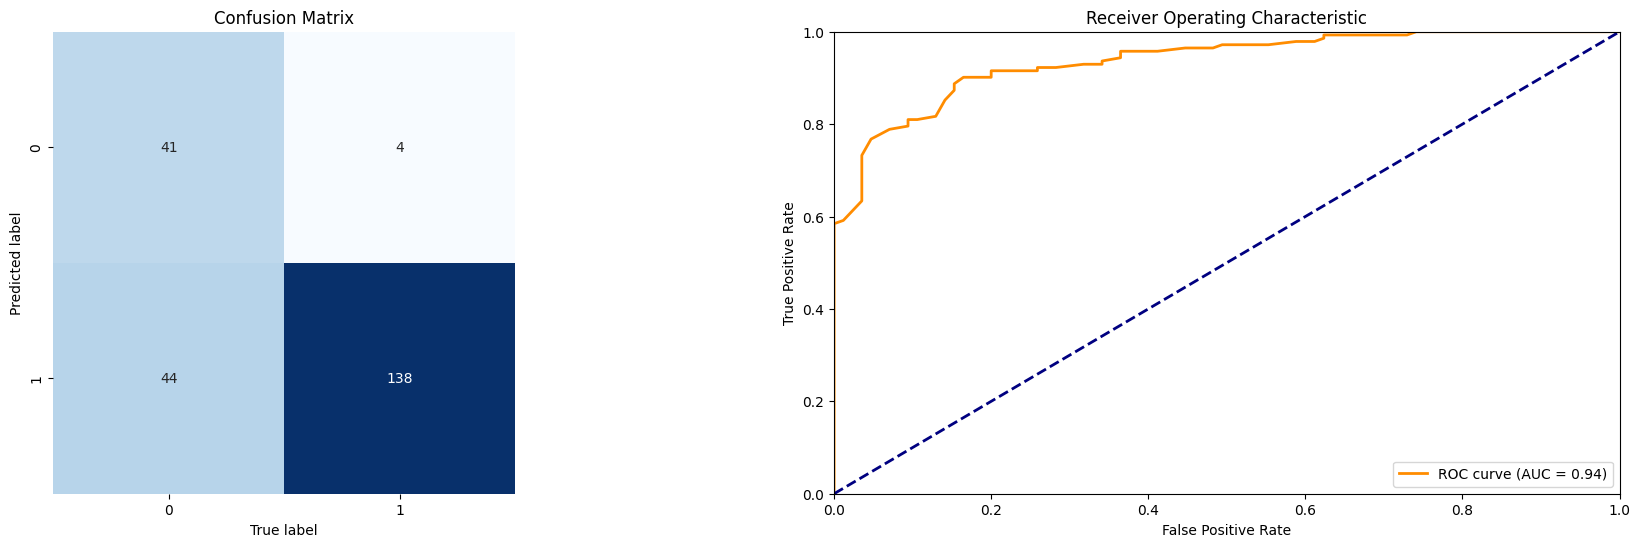

CPU times: total: 250 ms
Wall time: 669 ms


In [143]:
%%time
# random forests on Count Vectors
fpr7, tpr7, roc_auc7  = summary_report(clf_rf, X_train_count, y_train, X_test_count)

### ROC curve summary

In [145]:
results

,Count Vectors,WordLevel TF-IDF,N-Gram Vectors,CharLevel Vectors
Logistic Regression,0.698113,0.716981,0.656604,0.735849
Support Vector Machine,0.709434,0.724528,0.649057,0.732075
Stochastic Gradient Descent,0.649057,0.566038,0.554717,0.566038
Naive Bayes,0.698113,0.652830,0.649057,0.633962
K-Nearest Neighbors,0.645283,0.652830,0.649057,0.633962
Decision Tree,0.649057,0.675472,0.626415,0.724528
Random Forest,0.713208,0.720755,0.660377,0.784906


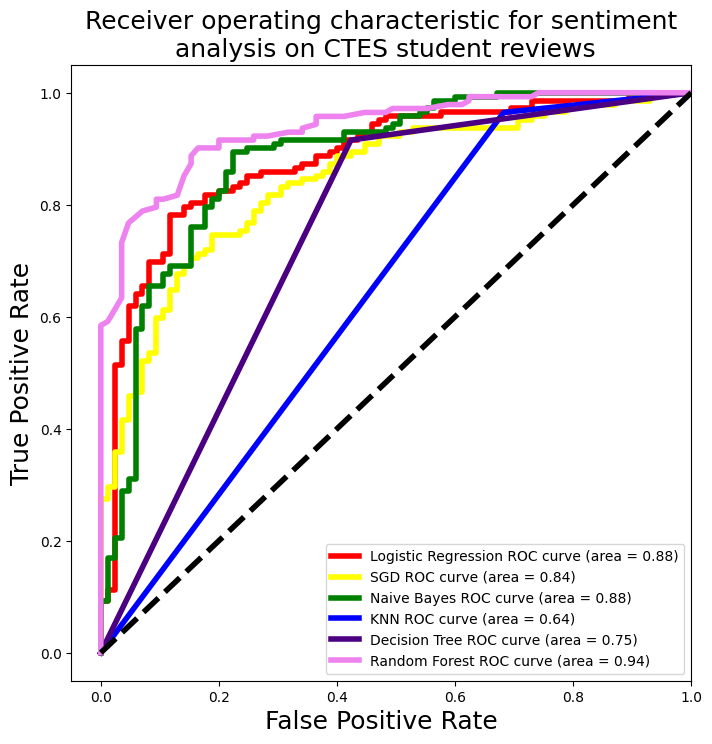

In [146]:
# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

# Plot fpr, tpr
plt.plot(fpr1, tpr1, color='red', lw=4, label = 'Logistic Regression ROC curve (area = %0.2f)' % roc_auc1)
plt.plot(fpr3, tpr3, color='yellow', lw=4, label = 'SGD ROC curve (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, color='green', lw=4, label = 'Naive Bayes ROC curve (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, color='blue', lw=4, label = 'KNN ROC curve (area = %0.2f)' % roc_auc5)
plt.plot(fpr6, tpr6, color='indigo', lw=4, label = 'Decision Tree ROC curve (area = %0.2f)' % roc_auc6)
plt.plot(fpr7, tpr7, color='violet', lw=4, label = 'Random Forest ROC curve (area = %0.2f)' % roc_auc7)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for sentiment\n analysis on CTES student reviews', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Load Best Trained Model

In [ ]:
import pickle
import joblib

In [149]:
# Load the saved model
with open('tfidf_vect_chars.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

In [151]:
# Load the saved model
with open('rf_model7.pkl', 'rb') as file:
    loaded_classifier = pickle.load(file)

In [152]:
# Check if the loaded vectorizer is the same as the original one
if np.array_equal(clf_rf, loaded_classifier):
    print("The code is correct. The model was successfully saved and loaded.")
else:
    print("There might be an issue. Please verify the saved and loaded model.")

There might be an issue. Please verify the saved and loaded model.


#### Testing on New Data

In [154]:
#Read csv file for validation
file = 'CTES Reviews 1.csv'
test_df = pd.read_csv(file)

In [155]:
translator = Translator()

In [156]:
try:
    # Translate reviews to English
    test_df['Review'] = test_df['Review'].apply(lambda x: translator.translate(x, src='ms', dest='en').text)
    print("Translation completed successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Translation completed successfully.


In [157]:
test_df.head(10)

,No.,Subject,Review
0,1,GFW0001,"This class is very helpful to me. Currently, I..."
1,2,GFW0001,like!Prof and TAs are helpful and the discussi...
2,3,GFW0001,Easy to follow and includes a lot of basic and...
3,4,GFW0001,Really nice teacher! I could get the point eas...
4,5,GFW0001,"Great course - I recommend it for all, especia..."
5,6,GFW0001,One of the most useful courses on IT Management!
6,7,GFW0001,I was disappointed because the name is mislead...
7,8,GFW0001,none
8,9,GFW0001,Super content. I'll definitely redo the course
9,10,GFW0002,-


In [162]:
with open('preprocessed_data.pkl','rb') as file:
    preprocess_text = pickle.load(file)

In [169]:
# Preprocess the text data 
test_df["Review"] = test_df["Review"].apply(preprocess_text)

In [170]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   No.      1950 non-null   int64 
 1   Subject  1950 non-null   object
 2   Review   1950 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.8+ KB


In [172]:
#Save the results
test_df.to_csv("cleaned_test.csv", index=False)

In [173]:
# Fill empty cells with the NaN value
test_df['Review'].replace([''], np.nan, inplace=True)

In [189]:
test_df['Review'].replace(['none', 'nothing','nil'], np.nan, inplace=True)

In [190]:
test_df.dropna(inplace=True)

In [191]:
#print(test_df['Review'].isnull().sum())
missing_values_count = test_df.isnull().sum()
print(missing_values_count)

No.          0
Subject      0
Review       0
Sentiment    0
dtype: int64


In [177]:
#Save the results
test_df.to_csv("cleaned_test_df.csv", index=False)

In [178]:
test_df.head(10)

,No.,Subject,Review
0,1,GFW0001,class helpful currently im still learning clas...
1,2,GFW0001,likeprof ta helpful discussion among student q...
2,3,GFW0001,easy follow include lot basic important techni...
3,4,GFW0001,really nice teacher could get point easily v
4,5,GFW0001,great course recommend especially business man...
5,6,GFW0001,one useful course management
6,7,GFW0001,disappointed name misleading course provide go...
7,8,GFW0001,none
8,9,GFW0001,super content ill definitely redo course
10,11,GFW0001,one excellent course coursera information tech...


In [179]:
# Now you can transform unseen data
X_unseen = test_df["Review"]
X_test_tfidf = tfidf_vectorizer.transform(X_unseen)

In [180]:
# Make predictions
y_pred = loaded_classifier.predict(X_test_tfidf)

In [184]:
test_df['Sentiment'] = y_pred

In [185]:
test_df.head(10)

,No.,Subject,Review,Sentiment
0,1,GFW0001,class helpful currently im still learning clas...,positive
1,2,GFW0001,likeprof ta helpful discussion among student q...,positive
2,3,GFW0001,easy follow include lot basic important techni...,positive
3,4,GFW0001,really nice teacher could get point easily v,positive
4,5,GFW0001,great course recommend especially business man...,positive
5,6,GFW0001,one useful course management,positive
6,7,GFW0001,disappointed name misleading course provide go...,positive
7,8,GFW0001,none,positive
8,9,GFW0001,super content ill definitely redo course,positive
10,11,GFW0001,one excellent course coursera information tech...,positive


In [186]:
test_df['Sentiment'].value_counts(normalize=True).mul(100).round(2)

Sentiment
positive    86.87
negative    13.13
Name: proportion, dtype: float64